In [1]:
import pandas as pd
import numpy as np
import laspy
from sklearn.metrics import precision_recall_fscore_support
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
import helper
import pickle
from tqdm import tqdm

In [2]:
# Set the figure format to support high DPI
%config InlineBackend.figure_format = 'retina'

#### Import and read synthetic point cloud (.las)

In [3]:
# Load the real point cloud
synth_pc_path = '/home/Meins/Uni/TUM/SS23/Data Lab/Data Sets/Synthetic/test_1.las'
synth_pc = laspy.read(synth_pc_path)

LasData
├─ header (LasHeader)
│   ├─ file_signature
│   ├─ file_source_id
│   ├─ global_encoding
│   ├─ ...
│
├─ points (LasPointRecord)
│   ├─ x
│   ├─ y
│   ├─ z
│   ├─ intensity
│   ├─ classification
│   ├─ ...
│
├─ raw_classification (optional)
├─ raw_scan_angle (optional)
├─ gps_time (optional)
├─ ...


In [4]:
# Some quick data information
header_synth = synth_pc.header
offsets_synth = [header_synth.x_offset, header_synth.y_offset, header_synth.z_offset]
print(offsets_synth)

# show maximum and minimum x, y, z values (offset substracted)
min_borders_synth = header_synth.min
max_borders_synth = header_synth.max
print(min_borders_synth - offsets_synth)
print(max_borders_synth - offsets_synth)

[0.0, 0.0, 0.0]
[4031.1340332  1015.59332275  411.802948  ]
[4589.5546875  1557.40942383  436.96670532]


In [5]:
class_descriptions = {
    1: 'Road',
    2: 'Ground',
    #3: 'Road Installations',
    6: 'Wall Surface',
    7: 'Roof Surface',
    8: 'Doors',
    9: 'Windows',
    10: 'Building Installations'
}
relevant_classes = list(class_descriptions.keys())

In [6]:
# Extract the relevant classes from the real point cloud
#real_points = real_pc.points
#real_labels = real_points['classification']
#relevant_indices = np.isin(real_labels, relevant_classes)
#relevant_points_real = real_points[relevant_indices]
#real_xyz = relevant_points_real[['x', 'y', 'z']]

#### Visualize point cloud

In [6]:
class_descriptions_synth = {
    0: 'None',
    1: 'Road',
    4: 'Walls',
    9: 'Vegetation',
    14: 'Car',
    25: 'Ground',
    31: 'Window',
    33: 'Door',
    37: 'Roof',
}

{0.0, 1.0, 33.0, 4.0, 37.0, 9.0, 14.0, 25.0, 31.0}


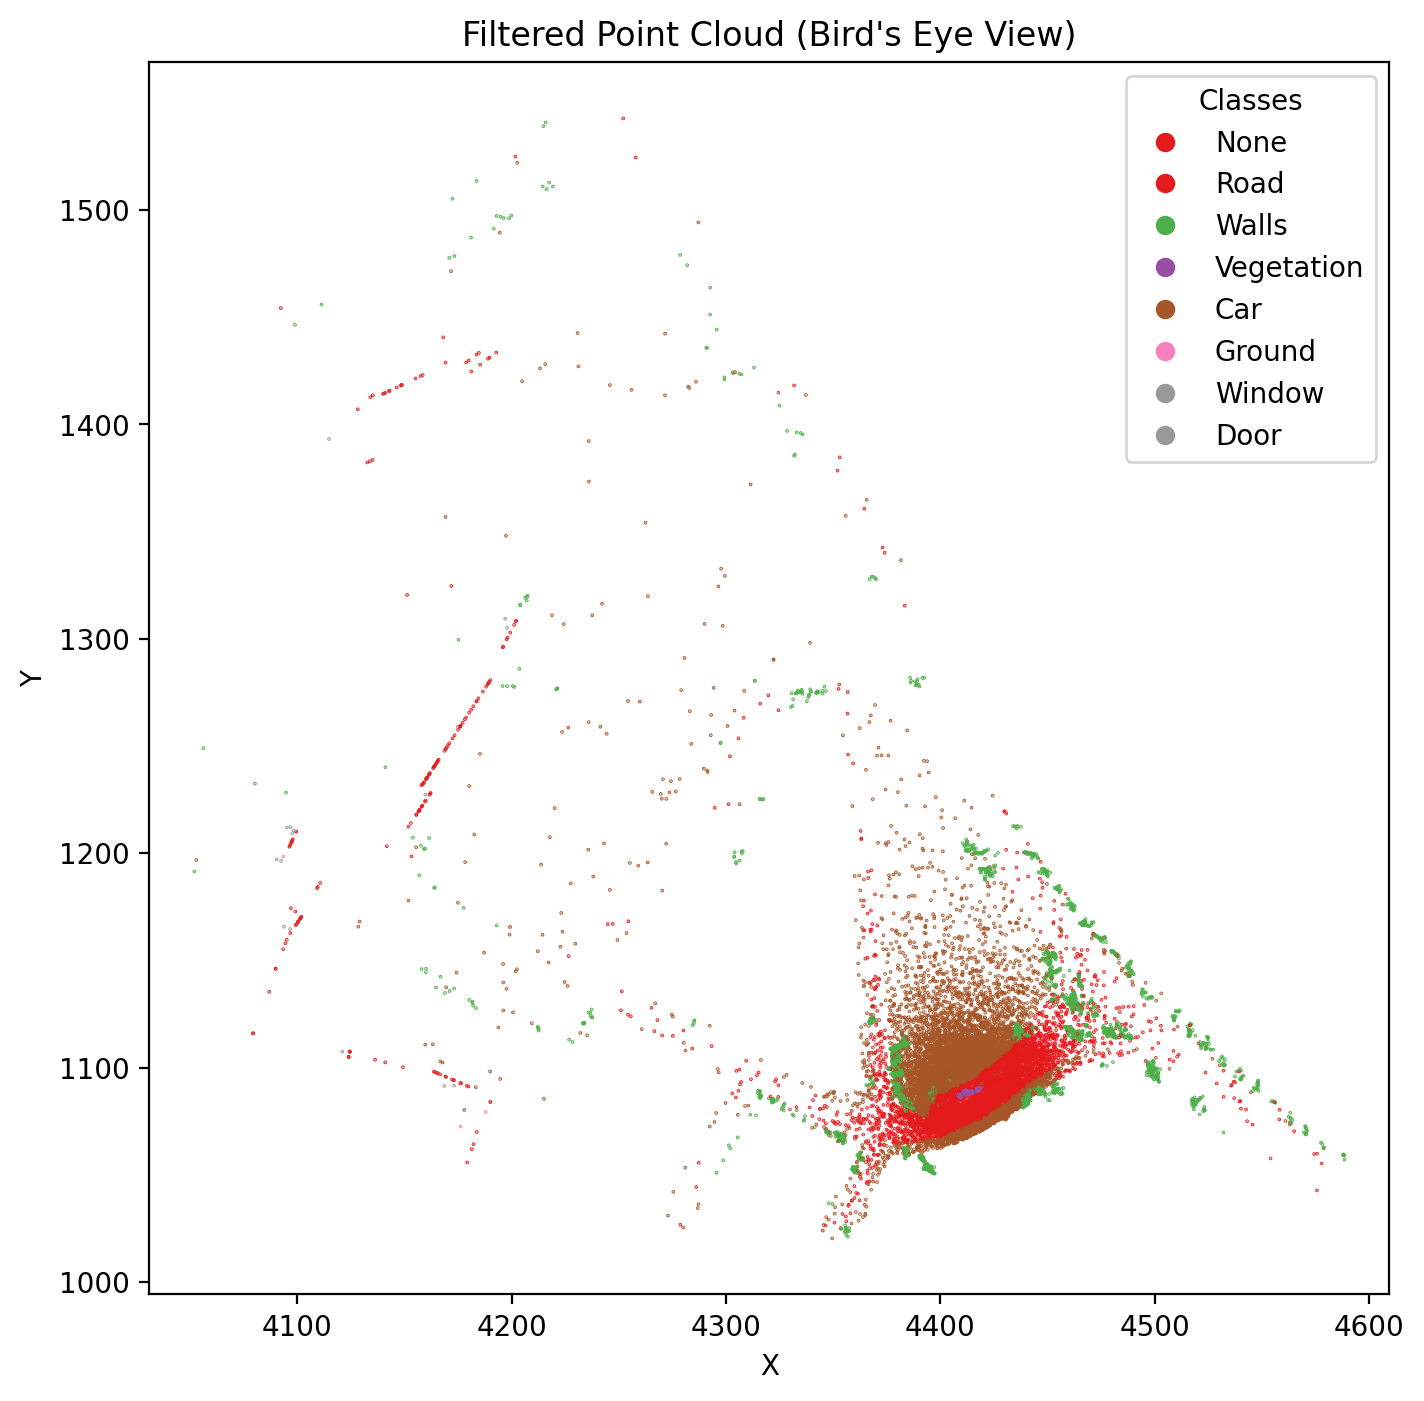

In [7]:
synth_points = synth_pc.points
classes = synth_points.semantic_tags
print(set(classes))
helper.plot_bev_synth(synth_points, class_descriptions_synth)

#### Load Real Point Cloud

In [9]:
# Load the real point cloud using helper function
real_pc_path = '/home/Meins/Uni/TUM/SS23/Data Lab/Labelling/Label-Datasets/valid/validation_classified_merge.las'
#real_points, _ = helper.import_and_prepare_point_clouds(real_pc_path, real_pc_path)
real_pc = laspy.read(real_pc_path)


In [10]:
# borders pc 1
header_1 = synth_pc.header
min_borders_1 = header_1.min
max_borders_1 = header_1.max


# borders pc 2
header_2 = real_pc.header
min_borders_2 = header_2.min
max_borders_2 = header_2.max


# bounding box & rectangular crop
padding = 1.0
min_xyz = np.maximum(min_borders_1, min_borders_2) 
max_xyz = np.minimum(max_borders_1, max_borders_2)
bounding_box = np.add(np.concatenate((min_xyz, max_xyz)), [-padding, -padding, -padding, padding, padding, padding])
cropped_points_1 = helper.crop_points(synth_pc.points, bounding_box)
cropped_points_2 = helper.crop_points(real_pc.points, bounding_box)

ValueError: zero-size array to reduction operation minimum which has no identity

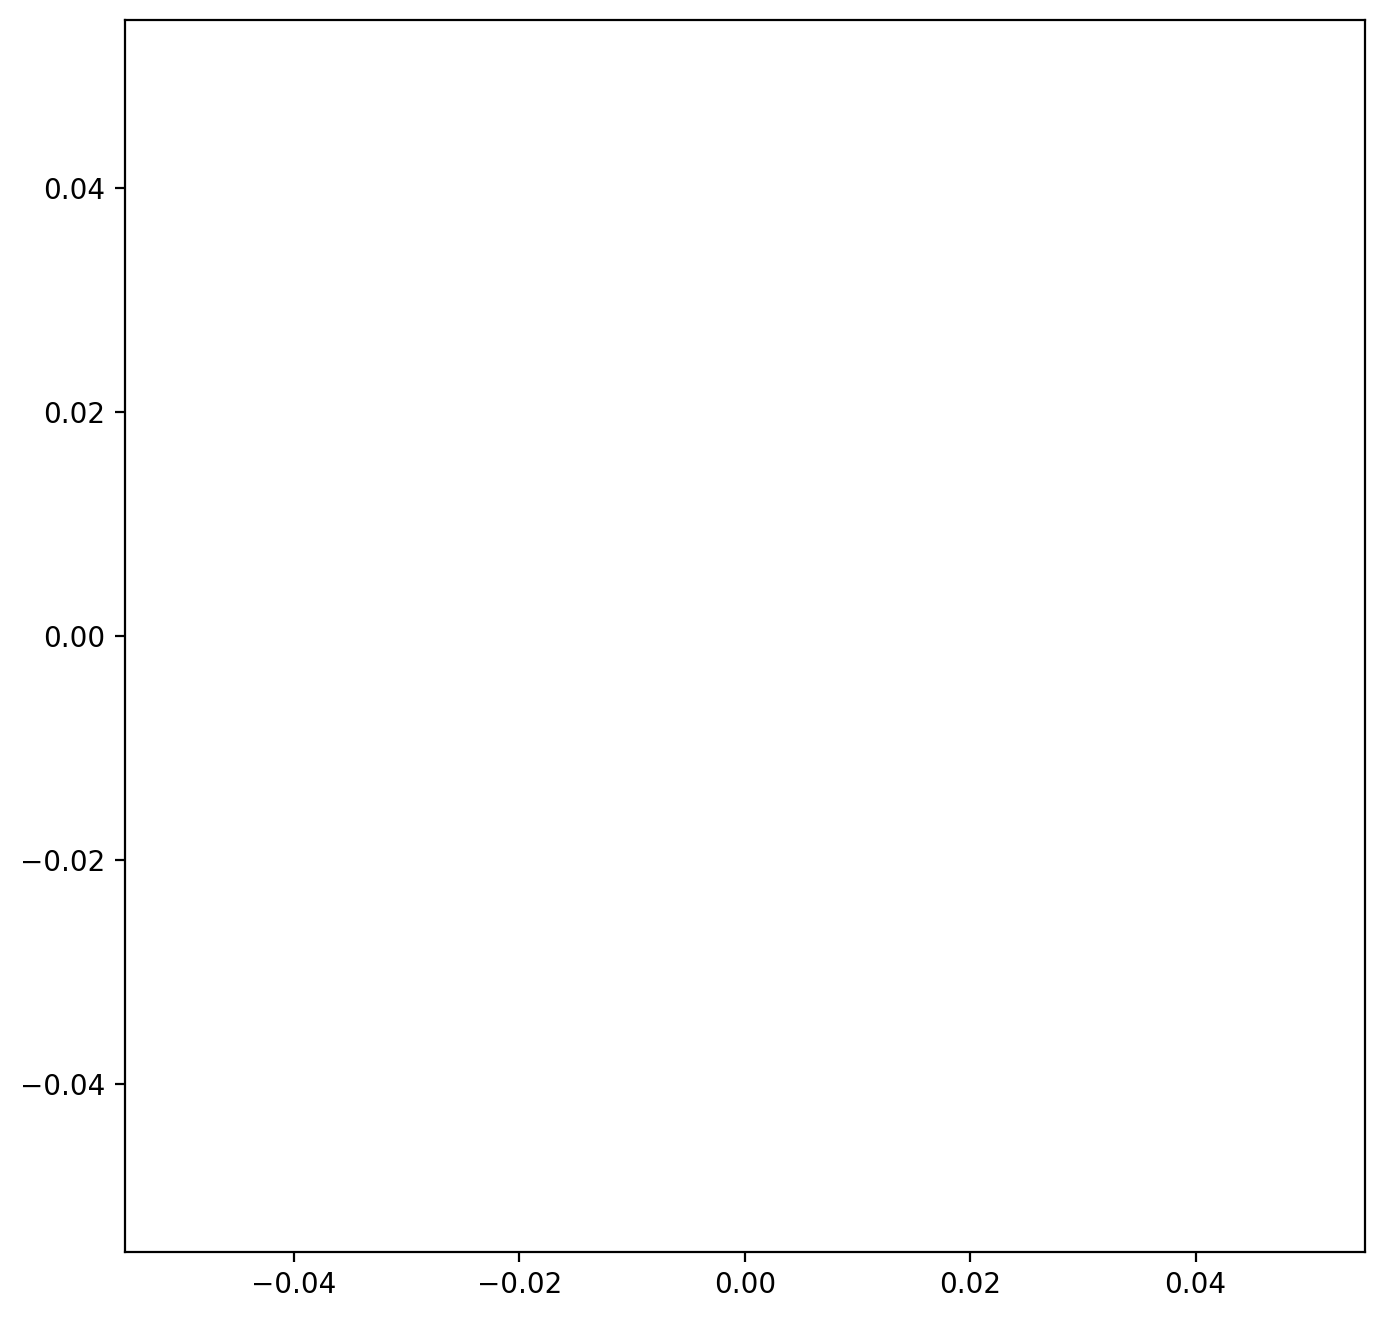

In [12]:
# proble if point cloud shifts do not match, then intersection of bounding boxes is empty and plotting crashes
# visualize synthetic point cloud
helper.plot_bev_synth(cropped_points_1, class_descriptions_synth)

#### Crop Point Clouds (intersection)

In [10]:
# borders constructed by relevent points only (e.g. noise points do not count)
# TODO: this takes ages to compute!
#max_xyz = np.minimum(np.amax(synth_xyz, axis=0), np.amax(real_xyz, axis=0)) # smallest upper bound
#min_xyz = np.maximum(np.amin(synth_xyz, axis=0), np.amin(real_xyz, axis=0)) # greatest lower bound

In [11]:
# TODO: IS THIS NECESSARY WHEN POINT COORDINATES ARE ABSOLUTE???
#  Shift point clouds (use header information). Both point clouds should have the same offset. 

In [12]:
# TODO: Bounding Box calculation based on class-filtered points?

In [13]:
# TODO: Use Convex hull for better cropping (intersection of two sets)?

#### Geometric Similarity (Haussdorff Distance)

In [10]:
# extract purely the coordinates of the points
real_xyz_cropped = real_points_cropped[['x', 'y', 'z']]
synth_xyz_cropped = synth_points_cropped[['x', 'y', 'z']]
# IDEA: do haussdorff distance only for each class/label

Convex hull objects need to be computed with the script.

In [15]:
# Load the ConvexHull object from disk
convex_hull_path_real = '/home/Meins/Uni/TUM/SS23/Data Lab/Labelling/Label-Datasets/valid/convex_hull_real.pkl'
with open(convex_hull_path_real, "rb") as file:
    loaded_convex_hull = pickle.load(file)

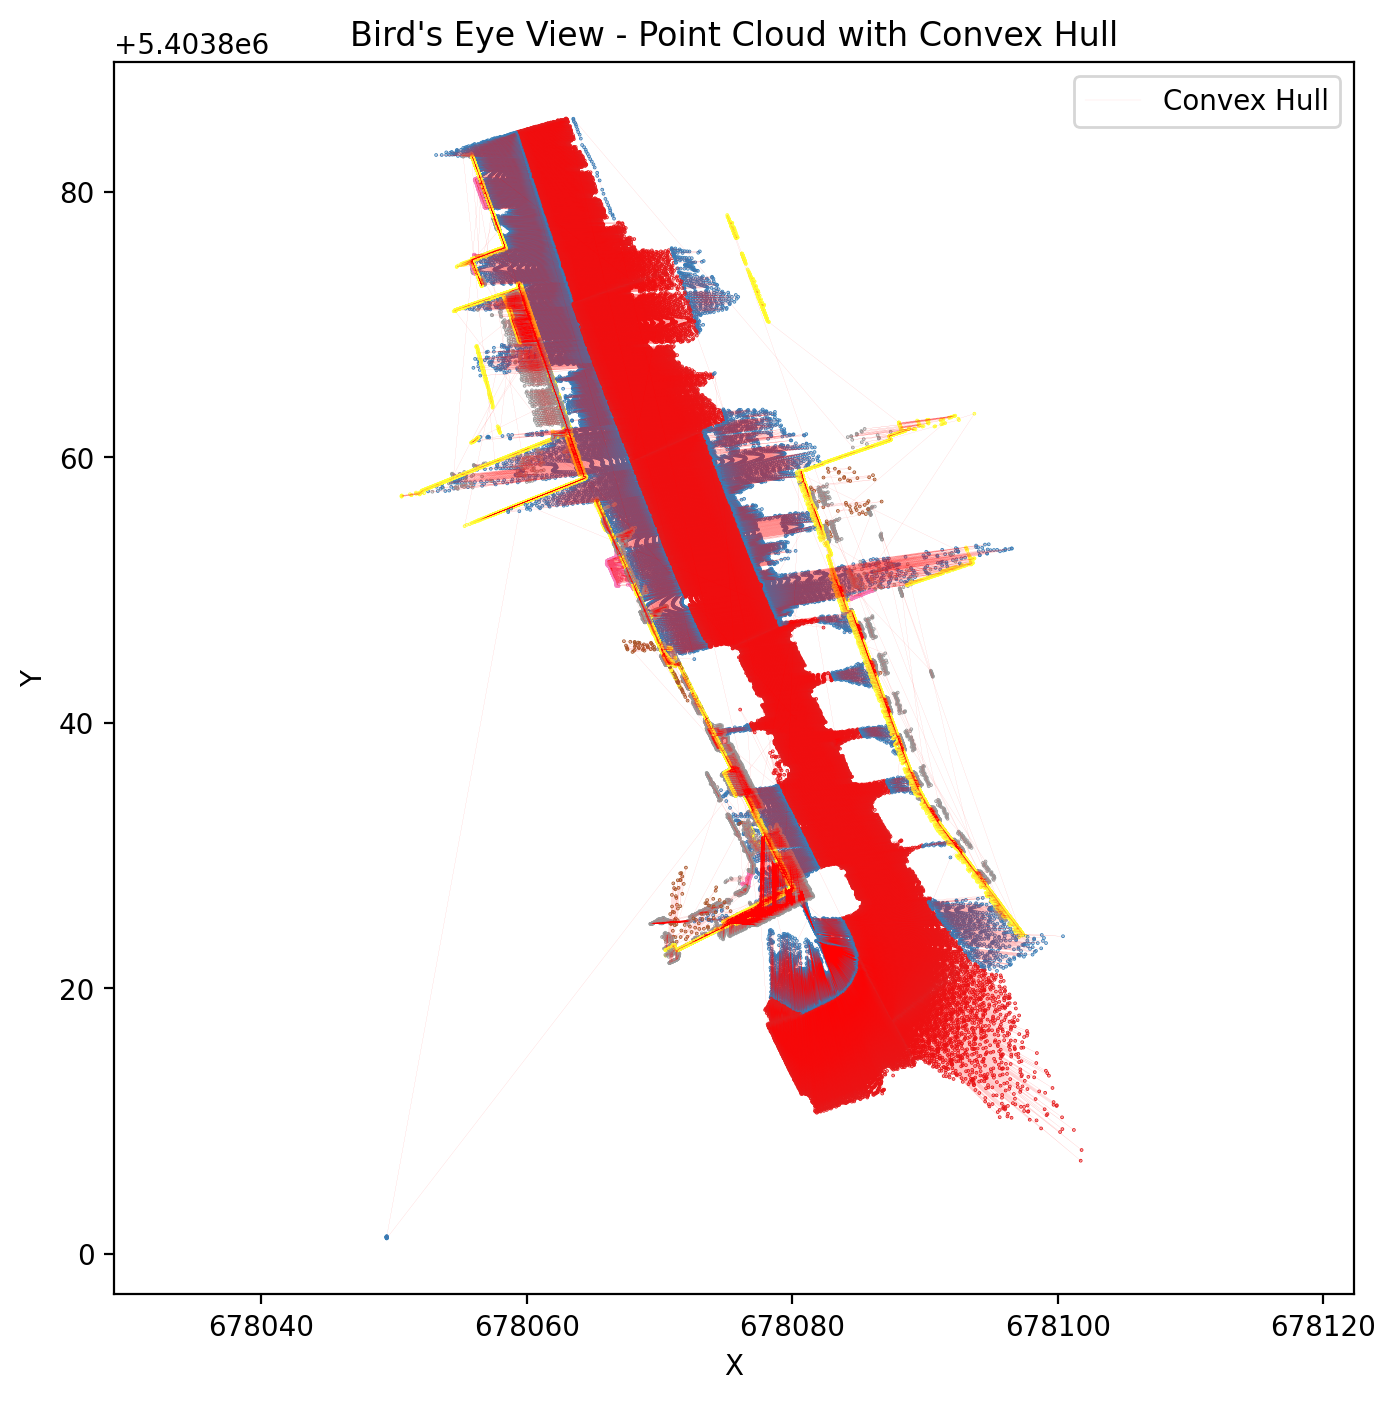

In [16]:
# Plot Convex hull in BEV over the data points
stride = 50
x = real_points_cropped['x'][::stride]
y = real_points_cropped['y'][::stride]
labels_sampled = real_points_cropped['classification'][::stride]

# Create a scatter plot of the point cloud
plt.figure(figsize=(8, 8))
scatter = plt.scatter(x, y, s=0.1, c=labels_sampled, cmap='Set1')

legend_colors = scatter.legend_elements(prop='colors')[0]


# Extract the x and y coordinates of the convex hull vertices
hull_vertices = loaded_convex_hull.points[:, :2]
hull_x = hull_vertices[:, 0][::stride]
hull_y = hull_vertices[:, 1][::stride]

plt.plot(hull_x, hull_y, color='red', linewidth=0.02, label='Convex Hull')
plt.legend(legend_colors, list(class_descriptions.values()), loc='upper right', title='Classes')
plt.title('Bird\'s Eye View - Point Cloud with Convex Hull')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.legend()
plt.show()

In [17]:
from scipy.spatial.distance import directed_hausdorff
def hausdorff_distance(point_set1, point_set2, hull1, hull2):

    distance1 = directed_hausdorff(point_set1, point_set2[hull2.vertices])[0]
    distance2 = directed_hausdorff(point_set2, point_set1[hull1.vertices])[0]

    return max(distance1, distance2)

In [18]:
# TIME INTENSIVE/CRASHES KERNEL
# Compute the geometric difference between the aligned point clouds.
convex_hull_real = loaded_convex_hull
convex_hull_synth = loaded_convex_hull
#haussdorff_distance = hausdorff_distance(real_xyz_cropped, synth_xyz_cropped, convex_hull_real, convex_hull_synth)

#### PyntCloud

In [11]:
# Load the real point cloud using helper function
synth_pc_path = '/home/Meins/Uni/TUM/SS23/Data Lab/Labelling/Label-Datasets/valid/validation_classified_merge.las'
cropped_points_1, cropped_points_2 = helper.import_and_prepare_point_clouds(real_pc_path, synth_pc_path)
cropped_cloud_1 = pyntcloud.PyntCloud(cropped_points_1)
cropped_cloud_2 = pyntcloud.PyntCloud(cropped_points_2)

NameError: name 'pyntcloud' is not defined